In [1]:
%matplotlib inline

## 1. Loading and normalizing MNIST


Using ``torchvision``, it’s extremely easy to load MNIST.

In [4]:
import torch
import torch.nn as nn 
from torch import optim
from torch.autograd import Variable
from torch.utils import data
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix
import seaborn as sn


Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


We need to normalize images before starting. Normally intensity values of MNIST dataset are in [0,255]. The output of torchvision datasets are PILImage images of range [0, 1]. So we do not need to normalize them here. However it is always good to check the values before starting the training.

In [1]:
def prepare_dataset(train_all, train_index, test_all, test_index, mode):
    transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    
    if not train_all:
        train_classes = {}
        new_label = 0        
        for i in train_index:
                train_classes[i] = new_label
                new_label = new_label + 1
                
    if mode == 'train':
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
        if not train_all: 
            idx = torch.ByteTensor(len(trainset.targets))*0
            for i in train_index:
                idx = idx | (trainset.targets==i)
            trainset.targets = trainset.targets[idx]
            trainset.data = trainset.data[idx]
            for k,v in train_classes.items():
                trainset.targets[trainset.targets==k] = v
        return trainset
    
    else:
        testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
        if not test_all:
            idx = torch.ByteTensor(len(testset.targets))*0
            for i in test_index:
                idx = idx | (testset.targets==i)
            testset.targets = testset.targets[idx]
            testset.data = testset.data[idx]
        if not train_all:
            for k,v in train_classes.items():
                testset.targets[testset.targets==k] = v        
        return testset
            

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')








Let us see some of the training images.

In [2]:
# 
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


def show_batch(loader):
    # get some random training images
    dataiter = iter(loader)
    images, labels = dataiter.next()

    # # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))
    return images, labels

In [5]:
# conservative softmax with polynomial drop 1/x^2, conservative soft = (1/z_i^2)/sum 1/z_k^2, dimension of z: batchsize * num_classes
class conservative_softmax(nn.Module): 
    def __init__(self, num_classes, a):
        super(conservative_softmax, self).__init__()
        self.num_classes = num_classes
        self.a = a
    def forward(self, input):
        nu = []
        pos = []
        for i in range(self.num_classes):
            nu.append(1/((self.a*input[:,i])**2 + 1e-20))
        for i in range(self.num_classes):
            pos.append(nu[i]/sum(nu))
        pos = torch.stack(pos, 1)
        return pos

In [6]:
class conservative_softmax_monotone(nn.Module): 
    def __init__(self, num_classes, a):
        super(conservative_softmax_monotone, self).__init__()
        self.num_classes = num_classes
        self.a = a
    def forward(self, input):
        nu = []
        pos = []
        for i in range(self.num_classes):
            nu.append(input[:,i] + torch.sqrt(1 + (input[:,i])**2))
        for i in range(self.num_classes):
            pos.append(nu[i]/sum(nu))
        pos = torch.stack(pos, 1)
        return pos

## 2. Define a Convolutional Neural Network


Please first check the [pytorch.nn](https://pytorch.org/docs/stable/nn.html) document in order to understand methods and how to use them.



In [8]:
import torch.nn.functional as F

use_gpu = torch.cuda.is_available()

class Net(nn.Module):
    def __init__(self, D_in, num_classes, conservative, a):
        super(Net, self).__init__()
        self.vgg = torchvision.models.vgg16(pretrained=False)
        if not conservative:
            self.softmax = nn.Softmax()
        elif conservative == 'monotone':
            self.softmax = conservative_softmax_monotone(num_classes, a)
        elif conservative == 'center':
            self.softmax = conservative_softmax(num_classes, a)

    def forward(self, x):
        z = self.vgg(x)
        x = self.softmax(z)
        return x, z


## 3. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize. If you want, also you can check the training time by using  ``time`` module in python.

In [9]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('runs')

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def train(train_loader, net, criterion, optimizer, epoch, args):
    net.train()
    train_loss = AverageMeter()
    Acc_v = 0
    nb = 0

    for i, data in enumerate(train_loader):
        X, Y = data 
        X = Variable(X)
        Y = Variable(Y).squeeze()
        N = len(X)
        nb = nb+N

        outputs, _ = net(X)
        # print('max train posterior:')
        # print(outputs.max(1)[0])
        Acc_v = Acc_v + (outputs.argmax(1) - Y).nonzero().size(0)
        loss = criterion(outputs, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.update(loss.data.item(), N)     
        if epoch % args['print_freq'] == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f]' % (epoch, i + 1, len(train_loader), train_loss.avg))

    train_acc = (nb - Acc_v)/nb
    # print("train acc: %.5f"%train_acc)
    return train_acc

In [11]:
def test(test_loader, net):
    net.eval()
    Acc_y = 0
    nb = 0
    for i, data in enumerate(test_loader):
        X, Y = data 
        X = Variable(X)
        Y = Variable(Y.squeeze()) 
        nb = nb + len(X)

        outputs, _ = net(X)
        # print('test posterior:')
        # print(outputs.max(1)[0], outputs.max(1)[1])
        Acc_y = Acc_y + (outputs.argmax(1) - Y).nonzero().size(0)
  
    test_acc = (nb - Acc_y)/nb 
    #print("test acc: %.5f"%test_acc)
    return test_acc

In [12]:
def main(args):
    net = Net(args['input_dimension'], args['num_classes'], args['conservative'], args['conservative_a'])
    trainset = prepare_dataset(args['train_all'], args['train_index'], args['test_all'], args['test_index'], 'train') 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=args['train_batch_size'],
                                              shuffle=True, num_workers=1)
    testset = prepare_dataset(args['train_all'], args['train_index'], args['test_all'], args['test_index'], 'test') 
    testloader = torch.utils.data.DataLoader(testset, batch_size=args['test_batch_size'],
                                         shuffle=False, num_workers=1)

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(net.parameters(), lr=args['lr'])

    best_Acc = 0 
    best_net = net
    for epoch in range(1, args['epoch'] + 1):
        train_acc = train(trainloader, net, criterion, optimizer, epoch, args)
        test_acc= test(testloader, net)     
        with open('cifar_train_accuracy.txt', 'a')as f:
            f.write('[epoch %d], train_accuracy is: %.5f\n' % (epoch, train_acc))
        with open('cifar_test_accuracy.txt', 'a')as f:
            f.write('[epoch %d], test_accuracy is: %.5f\n' % (epoch, test_acc))
        if best_Acc < test_acc:
            best_Acc = test_acc 
            best_net = net
    return best_Acc, best_net, testloader, trainloader

In [ ]:
hps = {'input_dimension': 1,
       'train_all': True,
       'train_index': [0,1],
       'test_all': True,
       'test_index': [0,1],
       'num_classes': 10,
       'train_batch_size': 32,
       'test_batch_size': 16,
       'epoch': 10,
       'lr': 1e-3,
       'print_freq':5,
       'conservative': False,
       'conservative_a': 0.1}
best_acc, net, testloader, trainloader = main(hps)

Files already downloaded and verified
Files already downloaded and verified


/home/ziqi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## 4. Check results

In [327]:
best_acc

0.9631

    7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5


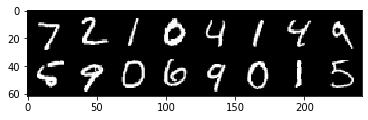

In [328]:
images, labels = show_batch(testloader)
# plt.savefig(path + 'train_batch.pdf', bbox_inches='tight')

Okay, now let us see what the neural network thinks these examples above are:

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let's get the index of the highest energy:

In [329]:
net.eval()
outputs, _ = net(images)
pos, y_hat = torch.max(outputs, 1)

print(y_hat)
print(pos)

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5])
tensor([0.9998, 0.9979, 0.9989, 0.9996, 0.9992, 0.9993, 0.9992, 0.9957, 0.9986,
        0.9921, 0.9996, 0.9987, 0.9932, 0.9996, 0.9994, 0.9989],
       grad_fn=<MaxBackward0>)


In [331]:
def per_class_acc(loader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs, r = net(images)
#             print(r)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(images)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / (1e-8 + class_total[i])))
        
per_class_acc(testloader)

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 97 %
Accuracy of     3 : 96 %
Accuracy of     4 : 99 %
Accuracy of     5 : 92 %
Accuracy of     6 : 96 %
Accuracy of     7 : 97 %
Accuracy of     8 : 95 %
Accuracy of     9 : 80 %


## 5. Representation goes to infinity

/home/ziqi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original prediction and posterior: [1] [1.]
prediction and posterior of perturbing all pixels in the representation:  [0] [1.]
average max posterior for perturbing each pixel in the representation: 1.00000


/home/ziqi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
/home/ziqi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


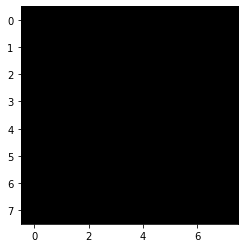

In [64]:
# size of mnist images: batchsize x 1 x 28 x 28
# make an attack image with the same size
img_attack = (images[2]).unsqueeze(0)
net.eval()
outputs, representation = net(img_attack)
pos, y_hat = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(img_attack))
imshow(torchvision.utils.make_grid(representation.detach().view(1,1,8,8)))
print('original prediction and posterior:', y_hat.detach().numpy(), pos.detach().numpy())

representation_all = representation.clone() - 1e10
imshow(torchvision.utils.make_grid(representation_all.detach().view(1,1,8,8)))
x = net.fc1(representation_all)
x = net.softmax(x)
pos, y_hat = torch.max(x, 1)
print('prediction and posterior of perturbing all pixels in the representation: ', y_hat.detach().numpy(), pos.detach().numpy())


pos_avg = 0
for i in range(representation.size()[1]):   
    xa = representation.clone()
    ori = xa[0,i]
    xa[0,i] = ori-1e10
    x = net.fc1(xa)    
    x = net.softmax(x)
    pos, y_hat = torch.max(x, 1)
    pos_avg = pos_avg + pos
    
print('average max posterior for perturbing each pixel in the representation: %.5f'%(pos_avg/64))
        

Text(0.5, 1, 'distances between representations of all samples in a batch')

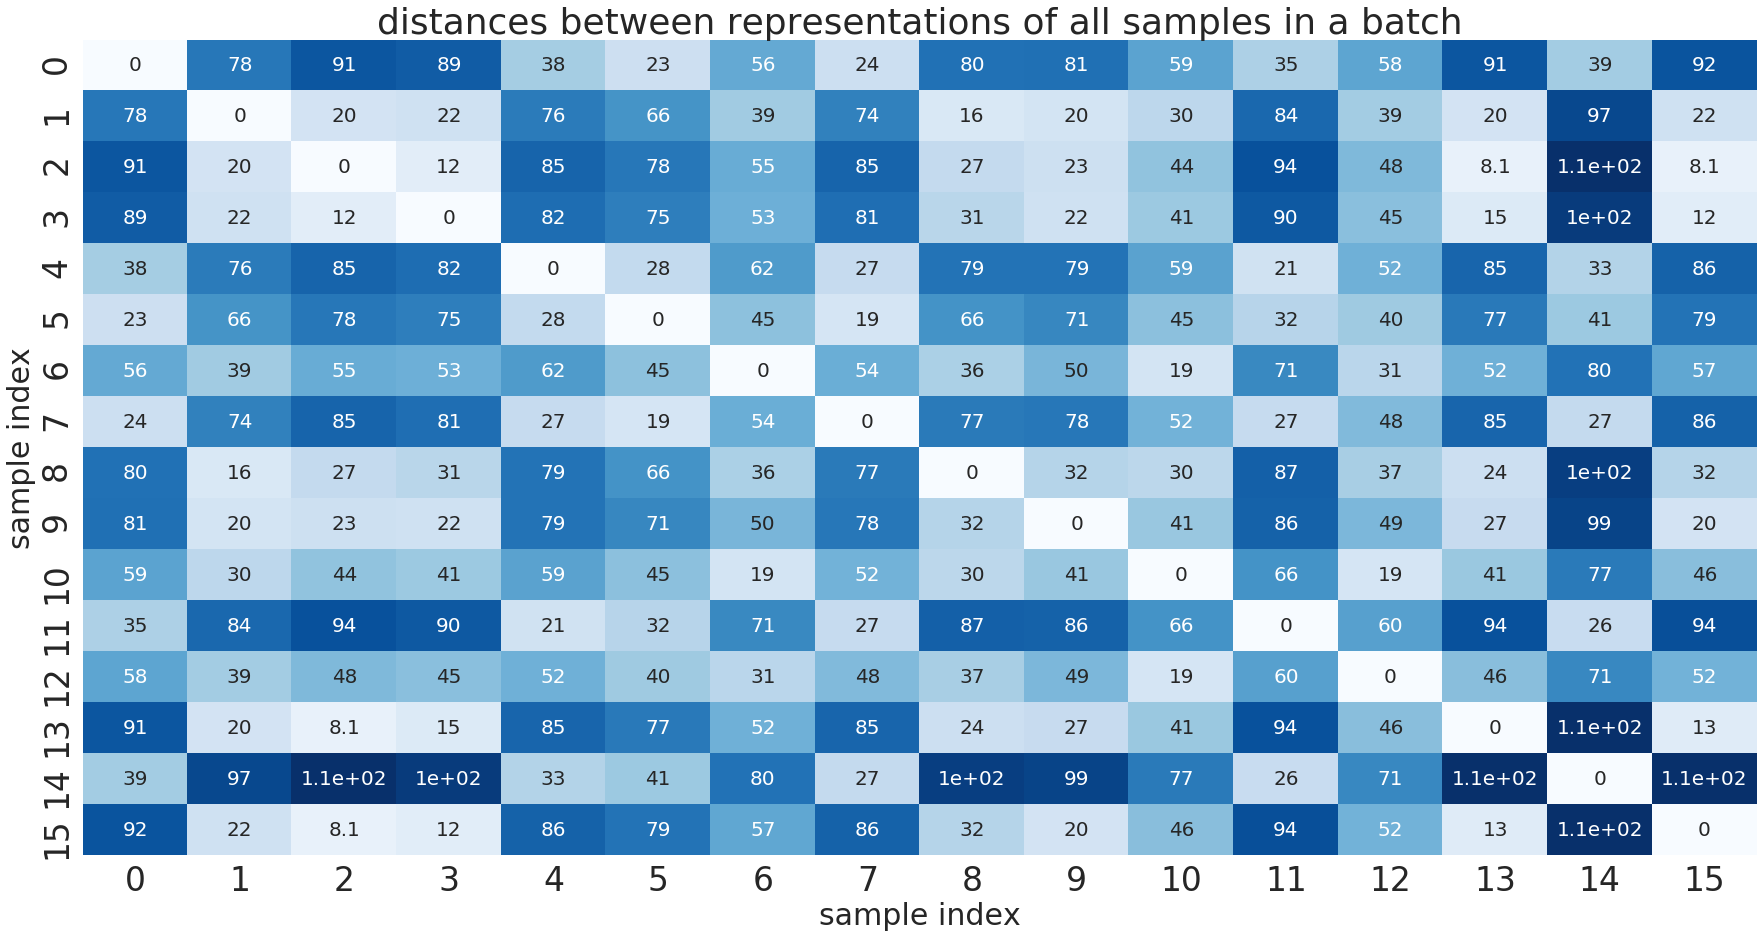

In [16]:
def distance(z1, z2):
    dis = torch.sqrt(torch.sum((z1-z2)**2))
    dis = dis.detach().numpy()
    return dis



dis = np.identity(hps['test_batch_size'])
for i in range(hps['test_batch_size']):
    for j in range(hps['test_batch_size']):
        img_attack1 = (images[i]).unsqueeze(0)
        _, representation1 = net(img_attack1)        
        img_attack2 = (images[j]).unsqueeze(0)
        _, representation2 = net(img_attack2)
        dis[i,j]=distance(representation1, representation2)

plt.figure(figsize = (30,15))
sn.set(font_scale=3)
sn.heatmap(dis, annot=True, cbar=False, annot_kws={"fontsize":20}, cmap='Blues')
plt.margins(0,0)
plt.xlabel('sample index', fontsize=30)
plt.ylabel('sample index', fontsize=30)
plt.title('distances between representations of all samples in a batch')

In [32]:
def check_weight_all(net):
    a = net.fc1.weight
    a = torch.sum(a,1)
    b = [1/torch.sum((i/a)**2).detach().numpy() for i in a]
    return b

pos_from_weight = check_weight_all(net)
print('posteriors calculated from weights:', pos_from_weight)

posteriors calculated from weights: [0.18726944065502585, 0.3210157874897872, 0.49171478436047655]


In [33]:
def check_weight_1D(net):
    pos_all_dimension = 0
    a = net.fc1.weight
    for i in range(a.size()[1]):
        a_1D = a[:,i]
        b = [1/torch.sum((j/a_1D)**2).detach().numpy() for j in a_1D]
        pos_all_dimension += max(b)
    pos_all_dimension_avg = pos_all_dimension/(a.size()[1])
    return pos_all_dimension_avg

pos_from_weight = check_weight_1D(net)
print('posteriors calculated from weights:', pos_from_weight)

posteriors calculated from weights: 0.8059156642472114


## 6. Adversarial Attack with FGSM

In [323]:
def fgsm_attack(model, loss, images, labels, eps) :
    
    images = images
    labels = labels
    images.requires_grad = True
            
    outputs, _ = model(images)

    model.zero_grad()
    cost = loss(outputs, labels)
    cost.backward()
    
    attack_images = images + eps*images.grad.sign()

#     attack_images = torch.clamp(attack_images, 0, 1)
    
    return attack_images

Attack Image & Predicted Label
Accuracy of     0 : 22 %
Accuracy of     1 :  8 %
Accuracy of     2 :  9 %
Accuracy of     3 : 11 %
Accuracy of     4 : 16 %
Accuracy of     5 :  0 %
Accuracy of     6 :  0 %
Accuracy of     7 :  2 %
Accuracy of     8 :  4 %
Accuracy of     9 :  0 %


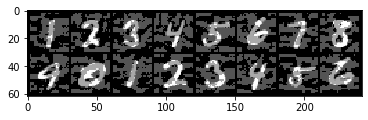

In [332]:
print("Attack Image & Predicted Label")

net.eval()

correct = 0
total = 0

eps = 0.25

def per_class_acc(loader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for data in loader:
        images, labels = data
        loss = nn.NLLLoss()

        images = fgsm_attack(net, loss, images, labels, eps)
        outputs, r = net(images)

        imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True))
    

        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(images)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / (1e-8 + class_total[i])))
        
per_class_acc(testloader)